# Model Training Notebook for Benchmark Simple MLP

This notebook is dedicated to training a simple MLP model focusing on longitudinal predictions in Alzheimer's disease progression. More specifically, the model is training to predict baseline cognition. This is done through the use of baseline regional tau data. This notebook covers:

>Note: This notebook trains on a larger dataset! Visit the `training_bench_small.ipynb` to run the training on the dataset as the LSTM model. 

### Data Preprocessing 
- Loading 
- Normalization
- Formatting
- Splitting

### Model Training
- Data conversion into tensors and datasets 
- K-fold cross validation 
- Training
- Loss curve plotting

### Model Analysis
- Correlation analysis 
- Prediction accuracy 

In [14]:
import pandas as pd 
import numpy as np
import mat4py
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from model import SimpleMLP

In [15]:
data = pd.read_csv('../data/Tau_with_Demographics.csv')
data

,merge_RID,MMSE_bl,ADAS11_bl,ADAS13_bl,merge_DX,best_DX,ctx-rh-bankssts,ctx-rh-caudalanteriorcingulate,ctx-rh-caudalmiddlefrontal,ctx-rh-cuneus,...,W_average_tau,W_average_frontal,W_average_temporal,W_average_parietal,W_average_occipital,ml_subtype,prob_ml_subtype,ml_stage,prob_ml_stage,Unnamed: 127
0,21,30,6.67,9.67,CN,CN,1.2475,1.0892,1.0955,1.1562,...,-0.046907,0.339853,1.036789,0.601625,1.100572,0.0,1.0,3.0,0.166798,NaN
1,31,30,1.67,1.67,CN,CN,1.1139,1.1076,1.0328,1.0991,...,-0.109110,0.414346,0.930375,0.573440,0.406073,0.0,1.0,4.0,0.149829,NaN
2,31,30,1.67,1.67,CN,CN,1.0569,1.0586,1.0009,1.0735,...,-0.099811,0.414346,0.930375,0.573440,0.406073,0.0,1.0,4.0,0.149857,NaN
3,56,28,3.00,3.00,MCI,EMCI,1.2538,1.1106,1.1190,1.1746,...,-0.009005,0.676851,0.821165,0.721422,1.261718,0.0,1.0,4.0,0.149921,NaN
4,56,28,3.00,3.00,MCI,EMCI,1.2577,1.1456,1.1177,1.1838,...,0.008748,0.676851,0.821165,0.721422,1.261718,0.0,1.0,4.0,0.150014,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,6704,28,10.33,14.33,CN,SMC,1.2162,1.0774,1.0614,1.0889,...,-0.087506,1.535122,1.152178,0.608225,1.467432,0.0,1.0,6.0,0.168199,NaN
815,6705,25,19.33,27.33,Dementia,AD,1.1079,0.9254,0.9342,0.9448,...,-0.150065,0.368088,0.194553,0.006670,-0.165769,0.0,1.0,10.0,0.375510,NaN
816,6713,27,19.00,29.00,Dementia,AD,1.0330,0.8888,0.9048,0.9494,...,0.062978,-0.077413,-0.294780,-0.816025,-0.392363,0.0,1.0,0.0,0.201921,NaN
817,6721,25,19.67,29.67,Dementia,AD,1.2617,1.1233,1.0587,1.1351,...,0.005101,0.156117,-0.058634,0.073827,0.219533,0.0,1.0,10.0,NaN,NaN


In [16]:
#check which columns have nan values
data.isnull().sum()

merge_RID            0
MMSE_bl              0
ADAS11_bl            4
ADAS13_bl            5
merge_DX             0
                  ... 
ml_subtype           6
prob_ml_subtype      6
ml_stage             6
prob_ml_stage        6
Unnamed: 127       819
Length: 128, dtype: int64

In [17]:
# row that has nan adascog
data[data['ADAS11_bl'].isnull()]

,merge_RID,MMSE_bl,ADAS11_bl,ADAS13_bl,merge_DX,best_DX,ctx-rh-bankssts,ctx-rh-caudalanteriorcingulate,ctx-rh-caudalmiddlefrontal,ctx-rh-cuneus,...,W_average_tau,W_average_frontal,W_average_temporal,W_average_parietal,W_average_occipital,ml_subtype,prob_ml_subtype,ml_stage,prob_ml_stage,Unnamed: 127
262,4513,29,NaN,NaN,CN,EMCI,1.1629,0.9897,0.9684,1.1032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.439651,NaN
263,4513,29,NaN,NaN,CN,EMCI,1.1196,0.9917,0.9591,1.0357,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.209511,NaN
454,6038,30,NaN,NaN,CN,SMC,1.1116,0.9923,1.0562,1.0961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
455,6038,30,NaN,NaN,CN,SMC,1.0535,0.9316,1.0102,1.0626,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
data = data.dropna(subset=['ADAS11_bl'])

In [19]:
data.columns

Index(['merge_RID', 'MMSE_bl', 'ADAS11_bl', 'ADAS13_bl', 'merge_DX', 'best_DX',
       'ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate',
       'ctx-rh-caudalmiddlefrontal', 'ctx-rh-cuneus',
       ...
       'W_average_tau', 'W_average_frontal', 'W_average_temporal',
       'W_average_parietal', 'W_average_occipital', 'ml_subtype',
       'prob_ml_subtype', 'ml_stage', 'prob_ml_stage', 'Unnamed: 127'],
      dtype='object', length=128)

In [20]:
# drop columns that are not needed
data.drop(columns=['merge_RID', 'ADAS13_bl', 'merge_DX', 'best_DX', 'best_DX.1', 'RID.1', 'Diagnosis', 'ADAS11_bl.1', 'ADAS13_bl.1', 'merge_DX.1', 'merge_RID.1', 'MMSE_bl.1', 'W_average_hippo', 'W_average_tau', 'W_average_frontal', 'W_average_temporal', 'W_average_parietal', 'W_average_occipital', 'ml_subtype', 'prob_ml_subtype', 'ml_stage', 'prob_ml_stage', 'Unnamed: 127', 'Unnamed: 0', 'W_ADAS11', 'APOE4', 'FDG', 'PIB', 'AV45', 'ABETA', 'TAU', 'CDRSB'], inplace=True)

/tmp/ipykernel_9934/1231390343.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=['merge_RID', 'ADAS13_bl', 'merge_DX', 'best_DX', 'best_DX.1', 'RID.1', 'Diagnosis', 'ADAS11_bl.1', 'ADAS13_bl.1', 'merge_DX.1', 'merge_RID.1', 'MMSE_bl.1', 'W_average_hippo', 'W_average_tau', 'W_average_frontal', 'W_average_temporal', 'W_average_parietal', 'W_average_occipital', 'ml_subtype', 'prob_ml_subtype', 'ml_stage', 'prob_ml_stage', 'Unnamed: 127', 'Unnamed: 0', 'W_ADAS11', 'APOE4', 'FDG', 'PIB', 'AV45', 'ABETA', 'TAU', 'CDRSB'], inplace=True)


In [21]:
data

,MMSE_bl,ADAS11_bl,ctx-rh-bankssts,ctx-rh-caudalanteriorcingulate,ctx-rh-caudalmiddlefrontal,ctx-rh-cuneus,ctx-rh-entorhinal,ctx-rh-fusiform,ctx-rh-inferiorparietal,ctx-rh-inferiortemporal,...,Right-Accumbens-area,Right-VentralDC,RID,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,PTAU
0,30,6.67,1.2475,1.0892,1.0955,1.1562,1.1607,1.2316,1.1644,1.3261,...,1.3873,1.3700,21,72.6,Female,18,Not Hisp/Latino,Black,Divorced,NaN
1,30,1.67,1.1139,1.1076,1.0328,1.0991,1.2740,1.1573,1.0765,1.1192,...,1.2469,1.2306,31,77.7,Female,18,Not Hisp/Latino,White,Widowed,22.55
2,30,1.67,1.0569,1.0586,1.0009,1.0735,1.2171,1.1320,1.0301,1.0547,...,1.1791,1.1674,31,77.7,Female,18,Not Hisp/Latino,White,Widowed,22.55
3,28,3.00,1.2538,1.1106,1.1190,1.1746,1.2623,1.2372,1.1783,1.2294,...,1.2582,1.3548,56,69.6,Female,13,Not Hisp/Latino,Black,Widowed,12.23
4,28,3.00,1.2577,1.1456,1.1177,1.1838,1.2191,1.2115,1.1928,1.2174,...,1.2479,1.3791,56,69.6,Female,13,Not Hisp/Latino,Black,Widowed,12.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,28,10.33,1.2162,1.0774,1.0614,1.0889,1.0830,1.1557,1.1285,1.1715,...,1.1515,1.2648,6704,65.3,Female,12,Hisp/Latino,White,Married,NaN
815,25,19.33,1.1079,0.9254,0.9342,0.9448,1.0273,1.0828,1.0061,1.0655,...,1.1304,1.1523,6705,74.9,Male,18,Not Hisp/Latino,White,Married,NaN
816,27,19.00,1.0330,0.8888,0.9048,0.9494,1.4117,1.1786,1.0054,1.2203,...,1.1515,1.1213,6713,71.1,Female,16,Not Hisp/Latino,White,Married,NaN
817,25,19.67,1.2617,1.1233,1.0587,1.1351,1.2295,1.2434,1.1906,1.2705,...,1.4672,1.4012,6721,77.9,Male,18,Not Hisp/Latino,White,Married,NaN


In [22]:
# extract cognitive scores, to be used as Y vals  
cog_scores = data.iloc[:, 0:2]
cog_scores

,MMSE_bl,ADAS11_bl
0,30,6.67
1,30,1.67
2,30,1.67
3,28,3.00
4,28,3.00
...,...,...
814,28,10.33
815,25,19.33
816,27,19.00
817,25,19.67


In [23]:
# extract regional tau across 86 regions
baseline_tau = data.iloc[:, 2:88]
baseline_tau

,ctx-rh-bankssts,ctx-rh-caudalanteriorcingulate,ctx-rh-caudalmiddlefrontal,ctx-rh-cuneus,ctx-rh-entorhinal,ctx-rh-fusiform,ctx-rh-inferiorparietal,ctx-rh-inferiortemporal,ctx-rh-isthmuscingulate,ctx-rh-lateraloccipital,...,Left-VentralDC,Right-Cerebellum-Cortex,Right-Thalamus-Proper,Right-Caudate,Right-Putamen,Right-Pallidum,Right-Hippocampus,Right-Amygdala,Right-Accumbens-area,Right-VentralDC
0,1.2475,1.0892,1.0955,1.1562,1.1607,1.2316,1.1644,1.3261,1.1529,1.1659,...,1.3654,1.0367,1.4502,1.2605,1.5012,1.6893,1.5871,1.2446,1.3873,1.3700
1,1.1139,1.1076,1.0328,1.0991,1.2740,1.1573,1.0765,1.1192,1.0939,1.0262,...,1.1874,1.0214,1.1399,1.0789,1.4155,1.6119,1.3522,1.2963,1.2469,1.2306
2,1.0569,1.0586,1.0009,1.0735,1.2171,1.1320,1.0301,1.0547,1.0850,1.0166,...,1.1836,1.0075,1.0777,0.9884,1.3432,1.5118,1.3250,1.3075,1.1791,1.1674
3,1.2538,1.1106,1.1190,1.1746,1.2623,1.2372,1.1783,1.2294,1.1732,1.1017,...,1.3716,1.0188,1.3359,1.2523,1.6850,1.8019,1.3568,1.2301,1.2582,1.3548
4,1.2577,1.1456,1.1177,1.1838,1.2191,1.2115,1.1928,1.2174,1.1917,1.1346,...,1.4087,0.9860,1.3640,1.2448,1.6487,1.8489,1.3794,1.2615,1.2479,1.3791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,1.2162,1.0774,1.0614,1.0889,1.0830,1.1557,1.1285,1.1715,1.0647,1.0902,...,1.2594,0.9930,1.1802,1.1326,1.4175,1.5608,1.1500,1.1447,1.1515,1.2648
815,1.1079,0.9254,0.9342,0.9448,1.0273,1.0828,1.0061,1.0655,0.9935,1.0041,...,1.1246,0.9868,1.1477,1.0165,1.4472,1.4985,1.1016,1.1784,1.1304,1.1523
816,1.0330,0.8888,0.9048,0.9494,1.4117,1.1786,1.0054,1.2203,0.9888,1.0187,...,1.1295,1.0018,1.0457,0.9666,1.2911,1.3663,1.3025,1.5126,1.1515,1.1213
817,1.2617,1.1233,1.0587,1.1351,1.2295,1.2434,1.1906,1.2705,1.3274,1.1319,...,1.3737,0.9982,1.4278,1.2245,1.6813,1.9355,1.3154,1.3254,1.4672,1.4012


In [24]:
# combine all columns in baseline tau into one column as an np array
baseline_tau = baseline_tau.apply(lambda x: np.array(x), axis=1)
baseline_tau


0      [1.2475, 1.0892, 1.0955, 1.1562, 1.1607, 1.231...
1      [1.1139, 1.1076, 1.0328, 1.0991, 1.274, 1.1573...
2      [1.0569, 1.0586, 1.0009, 1.0735, 1.2171, 1.132...
3      [1.2538, 1.1106, 1.119, 1.1746, 1.2623, 1.2372...
4      [1.2577, 1.1456, 1.1177, 1.1838, 1.2191, 1.211...
                             ...                        
814    [1.2162, 1.0774, 1.0614, 1.0889, 1.083, 1.1557...
815    [1.1079, 0.9254, 0.9342, 0.9448, 1.0273, 1.082...
816    [1.033, 0.8888, 0.9048, 0.9494, 1.4117, 1.1786...
817    [1.2617, 1.1233, 1.0587, 1.1351, 1.2295, 1.243...
818    [1.215, 1.0138, 0.966, 1.0416, 1.1378, 1.0907,...
Length: 815, dtype: object

In [25]:
# normalize ADAS11 and MMSE

adas11_mean = cog_scores['ADAS11_bl'].mean()
adas11_std = cog_scores['ADAS11_bl'].std()

mmse_mean = cog_scores['MMSE_bl'].mean()
mmse_std = cog_scores['MMSE_bl'].std()

cog_scores['ADAS11_bl'] = (cog_scores['ADAS11_bl'] - adas11_mean) / adas11_std
cog_scores['MMSE_bl'] = (cog_scores['MMSE_bl'] - mmse_mean) / mmse_std


cog_scores

,MMSE_bl,ADAS11_bl
0,0.776473,-0.443739
1,0.776473,-1.450793
2,0.776473,-1.450793
3,-0.236859,-1.182917
4,-0.236859,-1.182917
...,...,...
814,-0.236859,0.293425
815,-1.756856,2.106122
816,-0.743525,2.039656
817,-1.756856,2.174602


In [27]:
X = baseline_tau.values
y = cog_scores[['ADAS11_bl', 'MMSE_bl']].values


### Prepare data for training

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape



(torch.Size([570, 86]),
 torch.Size([570, 2]),
 torch.Size([245, 86]),
 torch.Size([245, 2]))

### Training

In [39]:
# import kfold
from sklearn.model_selection import KFold

#import SubsetRandomSampler
from torch.utils.data.sampler import SubsetRandomSampler

In [67]:
# k fold cross validation 
k = 5
num_epochs = 200
kf = KFold(n_splits=k, shuffle=True, random_state=42)
fold_train_losses = []
fold_val_losses = []
best_fold = None
min_val_loss = float('inf')

for fold, (train_ids, val_ids) in enumerate(kf.split(train_dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    train_subsampler = SubsetRandomSampler(train_ids)
    val_subsampler = SubsetRandomSampler(val_ids)
    
    train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_subsampler)
    val_loader = DataLoader(train_dataset, batch_size=32, sampler=val_subsampler)
    
    model = SimpleMLP(86, [64, 32, 16], 2)
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    training_loss  = []
    validation_loss = []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for data in train_loader:
            inputs, targets = data  
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * inputs.size(0)
        
        epoch_loss /= len(train_loader.dataset)
        training_loss.append(epoch_loss)

        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                inputs, targets = data
                outputs = model(inputs)
                loss = loss_function(outputs, targets)
                epoch_val_loss += loss.item() * inputs.size(0)
        
        epoch_val_loss /= len(val_loader.dataset)
        validation_loss.append(epoch_val_loss)

        if epoch_val_loss < min_val_loss:
            min_val_loss = epoch_val_loss
            best_fold = fold

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Training Loss: {epoch_loss:.4f}')
        print(f'Validation Loss: {epoch_val_loss:.4f}')
    
    print('--------------------------------')
    fold_train_losses.append(training_loss)
    fold_val_losses.append(validation_loss)

    torch.save(model.state_dict(), f'../models/simple_mlp_fold{fold}_full.pth')

FOLD 0
--------------------------------
Epoch 1/200
Training Loss: 0.8035
Validation Loss: 0.1418
Epoch 2/200
Training Loss: 0.7988
Validation Loss: 0.1418
Epoch 3/200
Training Loss: 0.7958
Validation Loss: 0.1421
Epoch 4/200
Training Loss: 0.7939
Validation Loss: 0.1421
Epoch 5/200
Training Loss: 0.7916
Validation Loss: 0.1393
Epoch 6/200
Training Loss: 0.7846
Validation Loss: 0.1356
Epoch 7/200
Training Loss: 0.7765
Validation Loss: 0.1322
Epoch 8/200
Training Loss: 0.7858
Validation Loss: 0.1320
Epoch 9/200
Training Loss: 0.7514
Validation Loss: 0.1314
Epoch 10/200
Training Loss: 0.7380
Validation Loss: 0.1451
Epoch 11/200
Training Loss: 0.7332
Validation Loss: 0.1230
Epoch 12/200
Training Loss: 0.7211
Validation Loss: 0.1187
Epoch 13/200
Training Loss: 0.7547
Validation Loss: 0.1280
Epoch 14/200
Training Loss: 0.7210
Validation Loss: 0.1334
Epoch 15/200
Training Loss: 0.7223
Validation Loss: 0.1190
Epoch 16/200
Training Loss: 0.6966
Validation Loss: 0.1192
Epoch 17/200
Training Los

In [68]:
best_fold

0


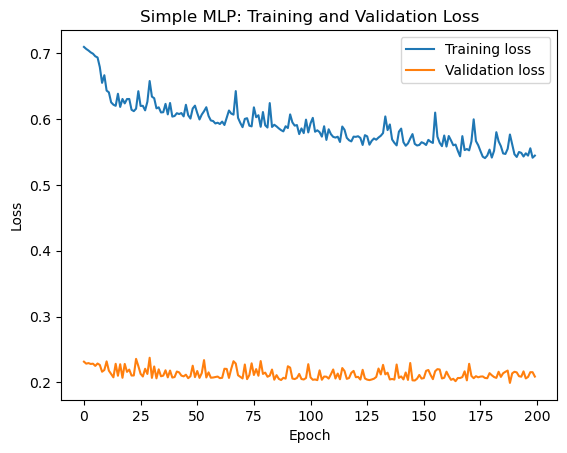

In [69]:
# plot best fold
import matplotlib.pyplot as plt

plt.plot(fold_train_losses[best_fold - 1], label='Training loss')
plt.plot(fold_val_losses[best_fold - 1], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Simple MLP: Training and Validation Loss')
plt.legend()
plt.show()

In [70]:
# load best fold
model.load_state_dict(torch.load(f'../models/simple_mlp_fold{best_fold}_full.pth'))
model.eval()

test_loader = DataLoader(test_dataset, batch_size=1)

# store predicted and true

predicted = []
true = []

with torch.no_grad():
    for data in test_loader:
        inputs, targets = data
        outputs = model(inputs)
        predicted.append(outputs)
        true.append(targets)

predicted[0][0][1]

tensor(-0.2938)

In [71]:
# unnormalize
for p in predicted:
    p[0][0] = p[0][0] * adas11_std + adas11_mean
    p[0][1] = p[0][1] * mmse_std + mmse_mean

for t in true:
    t[0][0] = t[0][0] * adas11_std + adas11_mean
    t[0][1] = t[0][1] * mmse_std + mmse_mean



Text(0.5, 1.0, 'ADAS Pearson Correlation: 0.4899')

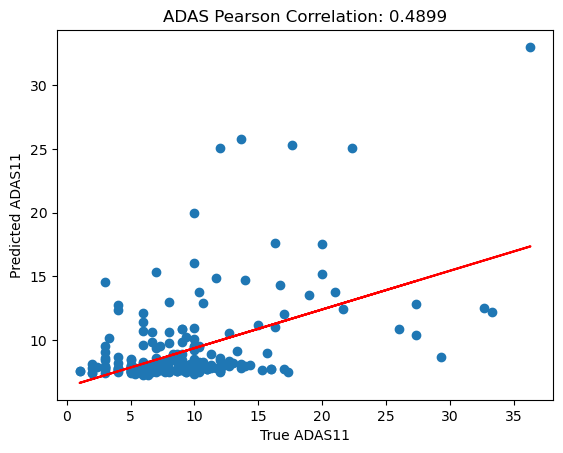

In [72]:
# plot correlations for adas 
predicted_adas = [p[0][0] for p in predicted]
true_adas = [t[0][0] for t in true]
pearson = np.corrcoef(true_adas, predicted_adas)
plt.scatter(true_adas, predicted_adas)
plt.xlabel('True ADAS11')
plt.ylabel('Predicted ADAS11')
m, b = np.polyfit(true_adas, predicted_adas, 1)
plt.plot(true_adas, m*np.array(true_adas) + b, color='red')
plt.title(f'ADAS Pearson Correlation: {pearson[0][1]:.4f}')

Text(0.5, 1.0, 'MMSE Pearson Correlation: 0.5029')

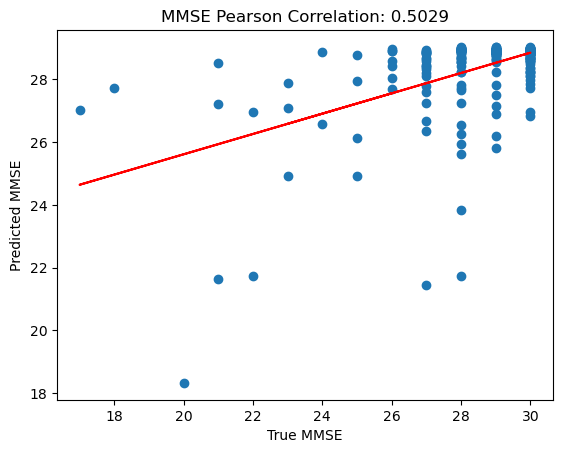

In [73]:
# plot correlations for mmse
predicted_mmse = [p[0][1] for p in predicted]
true_mmse = [t[0][1] for t in true]
pearson = np.corrcoef(true_mmse, predicted_mmse)
plt.scatter(true_mmse, predicted_mmse)
plt.xlabel('True MMSE')
plt.ylabel('Predicted MMSE')
m, b = np.polyfit(true_mmse, predicted_mmse, 1)
plt.plot(true_mmse, m*np.array(true_mmse) + b, color='red')
plt.title(f'MMSE Pearson Correlation: {pearson[0][1]:.4f}')


In [74]:
# pearson correlation
from scipy.stats import pearsonr

r, p = pearsonr(true_adas, predicted_adas)
print(f'Pearson correlation for ADAS11: {r:.4f}')

r, p = pearsonr(true_mmse, predicted_mmse)
print(f'Pearson correlation for MMSE: {r:.4f}')



Pearson correlation for ADAS11: 0.4899
Pearson correlation for MMSE: 0.5029
